# Ensemble size evaluation with a toy model

What ensemble size do I need for my prediction/predictability simulations and how will this affect my skill? How many members of each initialisation and how many initialisations to cover a suitable range of initial conditions in a perfect-model setup? Should I rather invest in more ensemble members or more initializations? In hindcast simulations there is only the question of how many members to be simulated.

These questions are sometimes asked when estimating required computational time and storage for prediction/predictability simulations. To visualize the effect of ensemble size on skill, we here develop a toy model which creates synthetic initialized ensembles. The are many parameters to tune the expected predictability features of these synthetic initialized ensembles, which this demo showcases. This model is inspired by Sienz et al. (2016) but rather focusing on perfect-model simulations:

- Sienz, Frank, Wolfgang A. Müller, and Holger Pohlmann. “Ensemble Size Impact on the Decadal Predictive Skill Assessment.” Meteorologische Zeitschrift, December 21, 2016, 645–55. https://doi.org/10/f9jrdx.


In [1]:
import xarray as xr
import warnings
from climpred.tutorial import load_dataset
import matplotlib.pyplot as plt
import numpy as np
warnings.filterwarnings("ignore")

In [2]:
# input amplitudes of the signal and noise or a control simulation
control = load_dataset('MPI-control-1D')['tos'].isel(period=-1, area=1)
noise_amplitude = control.std().values * 2.5 # factor is arbitrary, please re-check results from `create_initialized`
signal_amplitude = control.std().values
# period of potentially predictable variable
signal_P = 8

In [3]:
# over how many lead years to do want to create the initialized ensembles
lead = xr.DataArray(np.arange(0, 20, 1), dims='lead')
lead['lead'] = lead.values

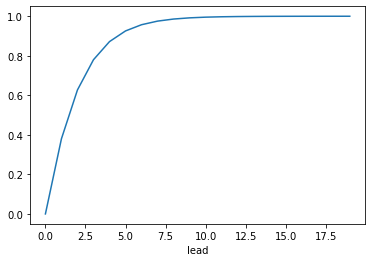

In [4]:
def ramp(t, a=0.2, A_tot=0.5, t_opt=0.1, r=1.8):
    """A weighting function that starts at 0 and approaches 1."""
    A = A_tot * (
        1.0 / (1 + a * np.exp((t_opt - t) / r)) -
        1.0 / (1 + a * np.exp((t_opt) / r))
    )
    A[0] = 0
    A = A / A[-1]
    return A


ramp(lead).plot()

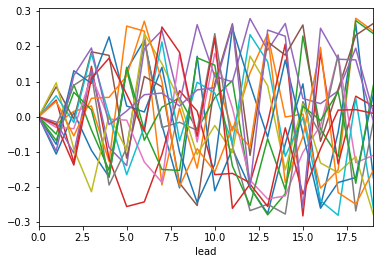

In [5]:
# gaussian noise starts from 0 can increases with the weighting by `ramp` up to noise_amplitude
from climpred.toy import create_noise
create_noise(noise_amplitude=noise_amplitude,nmember=3,ninit=5,
             ramp=ramp).to_dataframe('s').unstack().unstack()['s'].plot(legend=False)

## initialize ensemble
The toy model creates initialized ensembles based on different initial conditions but on the same underlying low-frequency variations with period $P$ superimposed on ramped-up gaussian noise.

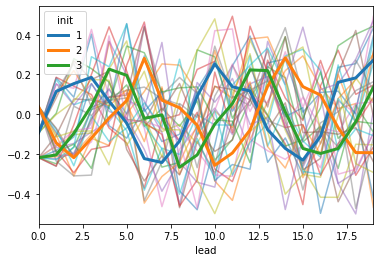

In [6]:
from climpred.toy import create_initialized
i = create_initialized(ninit=3)
i.to_dataframe('s').unstack().unstack().plot(alpha=0.5, legend=False)
i.mean('member').to_dataframe('mean').unstack()[
    'mean'].plot(ax=plt.gca(), lw=3)

## Comparison of spread in skill for different ensemble sizes

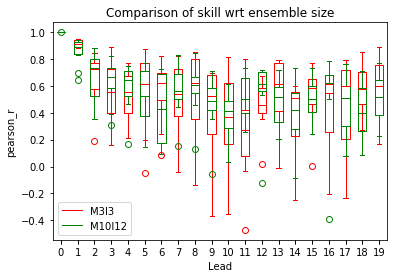

In [15]:
from climpred.toy import run_skill_for_ensemble
metric='pearson_r'
comparison='m2e'
small = run_skill_for_ensemble(nmember=3, ninits=3, metric=metric, comparison=comparison, color='r')
large = run_skill_for_ensemble(ax=plt.gca(),nmember=10, ninits=12, metric=metric, comparison=comparison, color='g')
plt.legend(handles=[small,large],labels=['M3I3','M10I12'])
plt.title('Comparison of skill wrt ensemble size')
plt.ylabel(metric)
plt.xlabel('Lead')
plt.show()

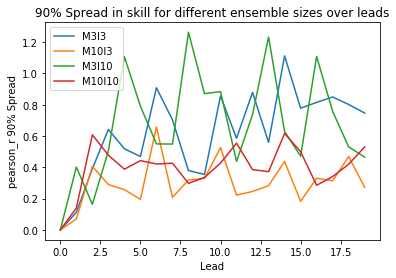

In [14]:
bootstrap=10
for n in [3,10]:
    for m in [3,10]:
        label=f'M{m}I{n}'
        sig = 0.05
        skill = run_skill_for_ensemble(nmember=m, ninits=n, metric=metric, comparison=comparison, plot=False, bootstrap=bootstrap)
        np.abs(skill.quantile(sig,'bootstrap')-skill.quantile(1-sig,'bootstrap')).plot(label=label)
plt.legend()
plt.ylabel(f'{metric} {int((1-sig*2)*100)}% Spread')
plt.xlabel('Lead')
plt.title(f'{int((1-sig*2)*100)}% Spread in skill for different ensemble sizes over leads')
plt.show()

In [12]:
sig = 0.05
bootstrap = 50
skill_spread = []
inits = [2,3,5,10,20]
members = [2,3,5,10,20]
for init in inits:
    s = []
    for member in members:
        label=f'M{m}I{n}'
        skill = run_skill_for_ensemble(nmember=member, ninits=init,
                                       metric=metric,comparison=comparison, plot=False, bootstrap=bootstrap).isel(lead=slice(-10,-1))
        s.append(np.abs(skill.quantile(sig,['bootstrap','lead'])-skill.quantile(1-sig,['bootstrap','lead'])))
    ss = xr.concat(s,'member')
    skill_spread.append(ss)
skill_spread = xr.concat(skill_spread,'init')
skill_spread['init']=inits
skill_spread['member']=members

Text(0.5, 1.0, '90% spread in skill')

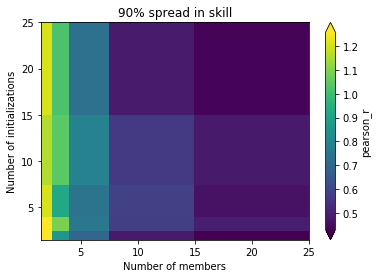

In [13]:
skill_spread.name = metric
skill_spread.plot(robust=True)
plt.ylabel('Number of initializations')
plt.xlabel('Number of members')
plt.title(f'{int((1-2*sig)*100)}% spread in skill')

## Bootstrap skill
The initialized ensemble is shuffled along the `init` dimension and thereby uninitialized. With initialized and uninitialized we can calculate skill significance with `bootstrap_perfect_model_toy`.

In [72]:
from climpred.toy import uninit_ensemble, bootstrap_perfect_model_toy
from climpred.graphics import plot_bootstrapped_skill_over_leadyear

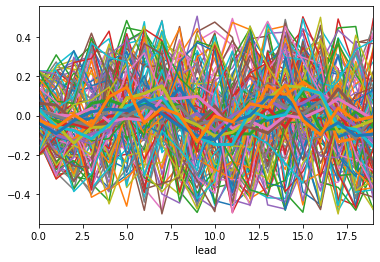

In [90]:
nmember = 10
ninits = 12
ds = create_initialized(nmember=nmember, ninits=ninits)
uninit = uninit_ensemble(ds, ds)
uninit.to_dataframe('s').unstack().unstack(0).plot(legend=False)
uninit.mean('member').to_dataframe('mean').unstack()[
    'mean'].plot(ax=plt.gca(), lw=3,legend=False)

Text(0, 0.5, 'mae')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


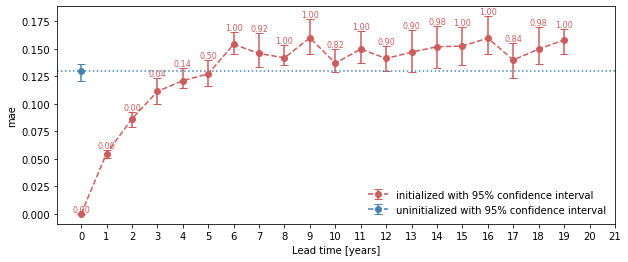

In [92]:
bootstrap = 50
metric='mae'
# fake reference dataset
fref = ds.rename({'init': 'time'}).isel(lead=0, member=0, drop=True)
bs = bootstrap_perfect_model_toy(ds, fref, metric=metric, bootstrap=bootstrap)
plot_bootstrapped_skill_over_leadyear(bs, sig=95, plot_persistence=False)
plt.ylabel(metric)